In [1]:
# ====== Setup & Imports ======
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDClassifier
from joblib import dump
import time
import shap
try:
  from google.colab import drive
  drive.mount('/content/drive')
except ImportError:
  pass

np.random.seed(42)

# ====== Output directories ======
BASE_OUT = "outputs"
DIRS = {
    "eda": os.path.join(BASE_OUT, "eda"),
    "feature_selection": os.path.join(BASE_OUT, "feature_selection"),
    "models": os.path.join(BASE_OUT, "models"),
    "metrics": os.path.join(BASE_OUT, "metrics"),
    "shap": os.path.join(BASE_OUT, "shap"),
    "kernel": os.path.join(BASE_OUT, "kernel_comparison"),
    "hyperparam": os.path.join(BASE_OUT, "hyperparam")
}
for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

# ====== Utility: save fig ======
def save_fig(path):
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print(f"Saved figure to: {path}")

class HIGGSDatasetAnalysis:
    def __init__(self, file_path):
        """
        Initialize the HIGGS dataset analysis
        :file_path: Path to the HIGGS dataset
        """
        self.data = self.load_data(file_path)
        self.X = None
        self.y = None

    def load_data(self, file_path):
        """
        Load the HIGGS dataset
        :file_path: Path to the dataset
        :return: Pandas DataFrame
        """
        data_org = pd.read_csv(file_path, header=None)
        data = data_org.sample(frac=0.01, random_state=42)
        return data

    def preprocess_data(self):
        """
        Preprocess the dataset
        1. Separate features and target
        2. Split into train and test sets
        3. Standardize features
        """
        # First column is the target, rest are features
        self.y = self.data.iloc[:, 0]
        self.X = self.data.iloc[:, 1:]

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        # Standardization
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        return self

    def exploratory_data_analysis(self):
        """
        Perform Exploratory Data Analysis
        1. Basic statistics
        2. Distribution plots
        3. Correlation heatmap
        """
        # Basic statistics
        print("Dataset Shape:", self.data.shape)
        print("\nTarget Distribution:")
        print(self.y.value_counts(normalize=True))

        # Feature distribution plots
        plt.figure(figsize=(15, 10))
        self.X.boxplot()
        plt.title("Feature Distributions")
        plt.xticks(rotation=90)
        plt.tight_layout()
        save_fig(os.path.join(DIRS["eda"], "feature_distributions_boxplot.png"))
        plt.show()

        # Correlation heatmap
        plt.figure(figsize=(15, 12))
        sns.heatmap(self.X.corr(), cmap='coolwarm', center=0)
        plt.title("Feature Correlation Heatmap")
        plt.tight_layout()
        save_fig(os.path.join(DIRS["eda"], "feature_correlation_heatmap.png"))
        plt.show()

        # Save target distribution as CSV
        self.y.value_counts(normalize=True).to_csv(
            os.path.join(DIRS["metrics"], "target_distribution.csv"),
            header=["proportion"]
        )

    def feature_selection(self, k_best=10):
        """
        Perform feature selection using SelectKBest
        :k_best: Number of top features to select
        :return: Selected features
        """
        selector = SelectKBest(score_func=f_classif, k=k_best)
        X_new = selector.fit_transform(self.X_train_scaled, self.y_train)

        # Get selected feature indices
        selected_indices = selector.get_support(indices=True)
        selected_features = self.X.columns[selected_indices]

        # Save selected features
        selected_df = pd.DataFrame({
            "selected_index": selected_indices,
            "feature_name": selected_features
        })

        print(f"\nTop {k_best} Selected Features:")
        for idx, feature in enumerate(selected_features, 1):
            print(f"{idx}. Feature {feature}")

        selected_df.to_csv(os.path.join(DIRS["feature_selection"], f"selectkbest_top{k_best}.csv"), index=False)
        print(f"Saved SelectKBest top-{k_best} features CSV.")

        return X_new, selected_features

    def train_linear_svm(self):
        """
        Train Linear SVM and evaluate performance
        """

        linear_svm = SGDClassifier(
            loss='log_loss',
            penalty='l2',
            max_iter=1000,
            tol=1e-3,
            random_state=42
        )

        # Cross-validation
        cv_scores = cross_val_score(linear_svm, self.X_train_scaled, self.y_train, cv=5)

        # Fit on entire training set
        linear_svm.fit(self.X_train_scaled, self.y_train)

        # Predictions
        y_pred = linear_svm.predict(self.X_test_scaled)

        # Build ROC-AUC
        y_score = None
        if hasattr(linear_svm, "decision_function"):
            scores = linear_svm.decision_function(self.X_test_scaled)
            # Convert to prob via sigmoid for ROC-AUC; alternatively use decision scores directly
            y_score = 1.0 / (1.0 + np.exp(-scores))

        # Performance metrics
        print("\nLinear SVM Performance:")
        print("Cross-Validation Scores:", cv_scores)
        print("Mean CV Score:", cv_scores.mean())
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))

        # Save metrics
        metrics = {
            "cv_scores": cv_scores.tolist(),
            "cv_mean": float(cv_scores.mean()),
            "accuracy": float(accuracy_score(self.y_test, y_pred)),
            "precision": float(precision_score(self.y_test, y_pred)),
            "recall": float(recall_score(self.y_test, y_pred)),
            "f1": float(f1_score(self.y_test, y_pred))
        }
        if y_score is not None:
            try:
                metrics["roc_auc"] = float(roc_auc_score(self.y_test, y_score))
            except Exception:
                pass

        # Save model
        model_path = os.path.join(DIRS["models"], "linear_sgd_svm.joblib")
        dump(linear_svm, model_path)
        print(f"Saved model: {model_path}")

        # Save metrics
        pd.DataFrame([metrics]).to_csv(os.path.join(DIRS["metrics"], "linear_svm_metrics.csv"), index=False)

        # Confusion matrix plot
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Linear SVM - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        save_fig(os.path.join(DIRS["metrics"], "linear_svm_confusion_matrix.png"))
        plt.show()

        #ROC curve
        if y_score is not None:
            fpr, tpr, _ = roc_curve(self.y_test, y_score)
            plt.figure(figsize=(5, 4))
            plt.plot(fpr, tpr, label=f"AUC={metrics.get('roc_auc', np.nan):.3f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.title("Linear SVM ROC")
            plt.legend()
            plt.tight_layout()
            save_fig(os.path.join(DIRS["metrics"], "linear_svm_roc.png"))
            plt.show()

        return linear_svm

    def kernel_comparison(self):
        """
        Compare different kernel configurations using parallel processing and efficient batch handling.
        The function evaluates 6 different SVM configurations:
        - 3 polynomial kernels (degrees 2, 3, 4)
        - 4 RBF kernels with different gamma values
        - 1 sigmoid kernel

        Returns: Dictionary containing performance metrics for each kernel configuration
        """
        from joblib import Parallel, delayed

        # Define kernel configurations for testing
        kernels = {
            'polynomial': {'kernel': 'poly', 'degrees': [2, 3, 4]},
            'rbf': {'kernel': 'rbf', 'gammas': ['scale', 'auto', 0.1, 1.0]},
            'sigmoid': {
                'kernel': 'sigmoid',
                'gamma_values': ['scale']
            }
        }

        results = {}

        def evaluate_kernel_config(kernel_name, **params):
            """
            Helper function to evaluate a single kernel configuration

            Returns: Performance metrics for the given configuration
            """
            params['C'] = params.get('C', 1.0)
            if kernel_name == 'sigmoid':
                params['tol'] = 1e-4

            svm = SVC(
                random_state=42,
                cache_size=500,
                class_weight='balanced',
                **params
            )
            return self._evaluate_kernel(svm, show_progress=False)

        # Prepare all kernel configurations for parallel processing
        kernel_configs = []

        # Generate polynomial kernel configurations
        for degree in kernels['polynomial']['degrees']:
            kernel_configs.append(
                ('poly', {
                    'kernel': 'poly',
                    'degree': degree,
                    'coef0': 1,
                    'C': 1.0
                })
            )

        # Generate RBF kernel configurations
        for gamma in kernels['rbf']['gammas']:
            kernel_configs.append(
                ('rbf', {
                    'kernel': 'rbf',
                    'gamma': gamma,
                    'C': 1.0
                })
            )

        # Generate single sigmoid kernel configuration
        kernel_configs.append(
            ('sigmoid', {
                'kernel': 'sigmoid',
                'gamma': 'scale',
                'coef0': 1.0,
                'C': 1.0
            })
        )

        print("\nEvaluating all kernel configurations in parallel...")

        # Process all kernels in parallel with optimized batch processing
        parallel_results = Parallel(
            n_jobs=-1,
            verbose=10,
            prefer="threads",
            batch_size='auto'
        )(
            delayed(evaluate_kernel_config)(name, **params)
            for name, params in kernel_configs
        )

        # Organize results
        for (name, params), result in zip(kernel_configs, parallel_results):
            if name == 'poly':
                results[f'Polynomial (degree={params["degree"]})'] = result
            elif name == 'rbf':
                results[f'RBF (gamma={params["gamma"]})'] = result
            else:
                results[f'Sigmoid (gamma={params["gamma"]})'] = result

        # Create summary DataFrame
        results_df = pd.DataFrame.from_dict(results, orient='index')
        results_df = results_df.sort_values('Accuracy', ascending=False)

        # Save results to CSV
        results_df.to_csv(os.path.join(DIRS["kernel"], "kernel_comparison_metrics.csv"))

        print("\nKernel Comparison Results (Sorted by Accuracy):")
        print(results_df)

        return results

    def _evaluate_kernel(self, svm, show_progress=True):
        """
        Optimized helper method to evaluate kernel performance using efficient batching
        """
        import time

        if show_progress:
            print(f"\nTraining {svm.kernel} kernel SVM...")

        # Training phase with optimized batch processing
        start_time = time.time()

        # Using smaller batches for training to maintain accuracy
        train_batch_size = min(5000, len(self.X_train_scaled))

        # Train using batches
        for i in range(0, len(self.X_train_scaled), train_batch_size):
            end_idx = min(i + train_batch_size, len(self.X_train_scaled))
            X_batch = self.X_train_scaled[i:end_idx]
            y_batch = self.y_train.iloc[i:end_idx]

            svm.fit(X_batch, y_batch)

        training_time = time.time() - start_time

        if show_progress:
            print(f"\nPredicting with {svm.kernel} kernel SVM...")

        start_time = time.time()

        test_batch_size = min(10000, len(self.X_test_scaled))
        predictions = []

        for i in range(0, len(self.X_test_scaled), test_batch_size):
            end_idx = min(i + test_batch_size, len(self.X_test_scaled))
            X_batch = self.X_test_scaled[i:end_idx]
            batch_pred = svm.predict(X_batch)
            predictions.extend(batch_pred)

        y_pred = np.array(predictions)
        prediction_time = time.time() - start_time

        # Calculate metrics
        metrics = {
            'Accuracy': accuracy_score(self.y_test, y_pred),
            'Precision': precision_score(self.y_test, y_pred),
            'Recall': recall_score(self.y_test, y_pred),
            'F1 Score': f1_score(self.y_test, y_pred),
            'Training Time': training_time,
            'Prediction Time': prediction_time
        }
        # ROC/AUC
        if hasattr(svm, "decision_function"):
            try:
                scores = svm.decision_function(self.X_test_scaled)
                y_score = 1.0 / (1.0 + np.exp(-scores))
                metrics["AUC"] = roc_auc_score(self.y_test, y_score)
            except Exception:
                pass

        return metrics

    def hyperparameter_tuning(self):
        """
        Perform hyperparameter tuning using RandomizedSearchCV with SGDClassifier.
        This function implements:
        1. Pipeline with standardization and SGD-based SVM
        2. Randomized search over hyperparameter space
        3. Batch processing for memory efficiency
        """

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SGDClassifier(
                loss='log_loss',
                max_iter=1000,
                tol=1e-3,
                random_state=42,
                eta0=0.1
            ))
        ])

        # Parameter grid for randomized search
        sgd_param_grid = {
            'svm__alpha': [0.0001, 0.001],
            'svm__eta0': [0.1, 0.01],
            'svm__learning_rate': ['constant', 'optimal']
        }

        print("\nPerforming hyperparameter tuning with RandomizedSearchCV...")
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=sgd_param_grid,
            n_iter=4,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )

        # Fit using batches
        batch_size = 5000
        for i in range(0, len(self.X_train_scaled), batch_size):
            end_idx = min(i + batch_size, len(self.X_train_scaled))
            X_batch = self.X_train_scaled[i:end_idx]
            y_batch = self.y_train.iloc[i:end_idx]
            if i == 0:
                random_search.fit(X_batch, y_batch)
            else:
                random_search.best_estimator_.fit(X_batch, y_batch)

        print("\nBest Hyperparameters:")
        print(random_search.best_params_)
        print("\nBest Cross-Validation Score:")
        print(random_search.best_score_)

        # Best model predictions using batches
        y_pred = []
        for i in range(0, len(self.X_test_scaled), batch_size):
            end_idx = min(i + batch_size, len(self.X_test_scaled))
            X_batch = self.X_test_scaled[i:end_idx]
            batch_pred = random_search.predict(X_batch)
            y_pred.extend(batch_pred)

        best_model = random_search.best_estimator_
        print("\nBest Model Performance:")
        print(classification_report(self.y_test, y_pred))

        # Save best model and tuning results
        dump(best_model, os.path.join(DIRS["models"], "best_sgd_pipeline.joblib"))
        pd.DataFrame([{
            "best_params": random_search.best_params_,
            "best_cv_score": random_search.best_score_
        }]).to_csv(os.path.join(DIRS["hyperparam"], "random_search_results.csv"), index=False)

        return random_search

    def hyperparameter_sensitivity(self):
        """
        Analyze and visualize the sensitivity of the SVM model to different hyperparameter combinations.
        This function:
        1. Tests combinations of C and gamma parameters
        2. Uses parallel processing for efficiency
        3. Creates a heatmap visualization of results

        Returns: Matrix of accuracy scores for different parameter combinations
        """
        from joblib import Parallel, delayed

        C_range = [0.1, 1, 10, 100]
        gamma_range = [0.1, 1, 10, 100]

        def evaluate_params(C, gamma, X_train, y_train, X_test, y_test):
            """
            Helper function to evaluate a single parameter combination using batches
            """
            svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)

            # Training with batches
            batch_size = 5000
            for i in range(0, len(X_train), batch_size):
                end_idx = min(i + batch_size, len(X_train))
                X_batch = X_train[i:end_idx]
                y_batch = y_train.iloc[i:end_idx]

                if i == 0:
                    svm.fit(X_batch, y_batch)
                else:
                    svm.fit(X_batch, y_batch)

            # Prediction with batches
            predictions = []
            for i in range(0, len(X_test), batch_size):
                end_idx = min(i + batch_size, len(X_test))
                X_batch = X_test[i:end_idx]
                batch_pred = svm.predict(X_batch)
                predictions.extend(batch_pred)

            return accuracy_score(y_test, predictions)

        print("\nEvaluating hyperparameter sensitivity...")

        # Prepare parameter combinations for parallel processing
        param_combinations = [
            (C, gamma) for C in C_range for gamma in gamma_range
        ]

        # Execute parameter evaluation in parallel
        results = Parallel(n_jobs=-1, verbose=1)(
            delayed(evaluate_params)(
                C, gamma,
                self.X_train_scaled,
                self.y_train,
                self.X_test_scaled,
                self.y_test
            )
            for C, gamma in param_combinations
        )

        # Reshape results into heatmap format
        heatmap_data = np.array(results).reshape(len(C_range), len(gamma_range))

        # Create visualization
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            heatmap_data,
            annot=True,
            cmap='YlGnBu',
            xticklabels=gamma_range,
            yticklabels=C_range,
            fmt='.3f'
        )
        plt.title('Hyperparameter Sensitivity Heatmap')
        plt.xlabel('Gamma')
        plt.ylabel('C')
        plt.tight_layout()
        save_fig(os.path.join(DIRS["hyperparam"], "rbf_svc_sensitivity_heatmap.png"))
        plt.show()

        # Save matrix
        pd.DataFrame(heatmap_data, index=C_range, columns=gamma_range).to_csv(os.path.join(DIRS["hyperparam"], "rbf_svc_sensitivity.csv"))
        return heatmap_data

def model_comparison_and_shap_analysis(higgs_analysis, linear_svm, kernel_results, best_model):
    """
    Compare SVM models and perform SHAP analysis with probability support
    """
    def create_model_comparison_report(linear_svm, kernel_results, best_model):
        """
        Create a comparison report of different SVM models
        """
        def get_predictions(model, X):
            if hasattr(model, 'predict_proba'):
                return model.predict_proba(X)[:, 1]
            else:
                decisions = model.decision_function(X)
                return 1 / (1 + np.exp(-decisions))

        # Get metrics using predictions
        lin_pred = linear_svm.predict(higgs_analysis.X_test_scaled)
        linear_svm_metrics = {
            'Accuracy': accuracy_score(higgs_analysis.y_test, lin_pred),
            'Precision': precision_score(higgs_analysis.y_test, lin_pred),
            'Recall': recall_score(higgs_analysis.y_test, lin_pred),
            'F1 Score': f1_score(higgs_analysis.y_test, lin_pred)
        }
        best_pred = best_model.predict(higgs_analysis.X_test_scaled)
        # Combine results
        best_metrics = {
            'Accuracy': accuracy_score(higgs_analysis.y_test, best_pred),
            'Precision': precision_score(higgs_analysis.y_test, best_pred),
            'Recall': recall_score(higgs_analysis.y_test, best_pred),
            'F1 Score': f1_score(higgs_analysis.y_test, best_pred)
        }
        results = {
            'Linear SVM': linear_svm_metrics,
            **kernel_results,
            'Best Model (Search)': best_metrics
        }
        df = pd.DataFrame.from_dict(results, orient='index')

        # Save to CSV
        df.to_csv(os.path.join(DIRS["metrics"], "model_comparison.csv"))
        return df

    def perform_shap_analysis(model, X_train, X_test, feature_names):
        """
        Perform SHAP analysis with support for both predict_proba and decision_function
        """
        # Wrapper class that provides predict_proba using decision_function
        class ProbabilityWrapper:
            def __init__(self, model):
                self.model = model

            def predict_proba(self, X):
                if hasattr(self.model, 'predict_proba'):
                    return self.model.predict_proba(X)
                else:
                    decisions = self.model.decision_function(X)
                    probs = 1 / (1 + np.exp(-decisions))
                    return np.vstack((1-probs, probs)).T

        wrapped_model = ProbabilityWrapper(model)

        X_train_arr = X_train.values if hasattr(X_train, 'values') else X_train
        X_test_arr = X_test.values if hasattr(X_test, 'values') else X_test

        # SHAP explainer
        print("Creating SHAP explainer...")
        explainer = shap.KernelExplainer(
            lambda x: wrapped_model.predict_proba(x)[:, 1],
            shap.kmeans(X_train_arr, 100)
        )

        # Calculate SHAP values for a sample of test data
        sample_size = min(100, len(X_test))
        print(f"Calculating SHAP values for {sample_size} samples...")
        shap_values = explainer.shap_values(X_test_arr[:sample_size])

        try:
            # Plot summary of feature importances
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values,
                X_test_arr[:sample_size],
                feature_names=feature_names[:len(feature_names)],
                plot_type="bar",
                show=False
            )
            plt.title("SHAP Feature Importance")
            plt.tight_layout()
            save_fig(os.path.join(DIRS["shap"], "shap_importance_bar.png"))
            plt.show()

            plt.clf()

            # Plot SHAP summary plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values,
                X_test_arr[:sample_size],
                feature_names=feature_names[:len(feature_names)],
                show=False
            )
            plt.title("SHAP Summary Plot")
            plt.tight_layout()
            save_fig(os.path.join(DIRS["shap"], "shap_summary.png"))
            plt.show()

        except Exception as e:
            print(f"Error creating SHAP plots: {str(e)}")

        return shap_values

    # Execute analysis with the fixed functions
    model_comparison = create_model_comparison_report(
        linear_svm, kernel_results, best_model
    )

    # Perform SHAP analysis on the best model
    shap_values = perform_shap_analysis(
        best_model,
        higgs_analysis.X_train_scaled,
        higgs_analysis.X_test_scaled,
        higgs_analysis.X.columns
    )

    return {
        'model_comparison': model_comparison,
        'shap_values': shap_values
    }

Mounted at /content/drive


Dataset Shape: (110000, 29)

Target Distribution:
0
1.0    0.528091
0.0    0.471909
Name: proportion, dtype: float64
Saved figure to: outputs/eda/feature_distributions_boxplot.png


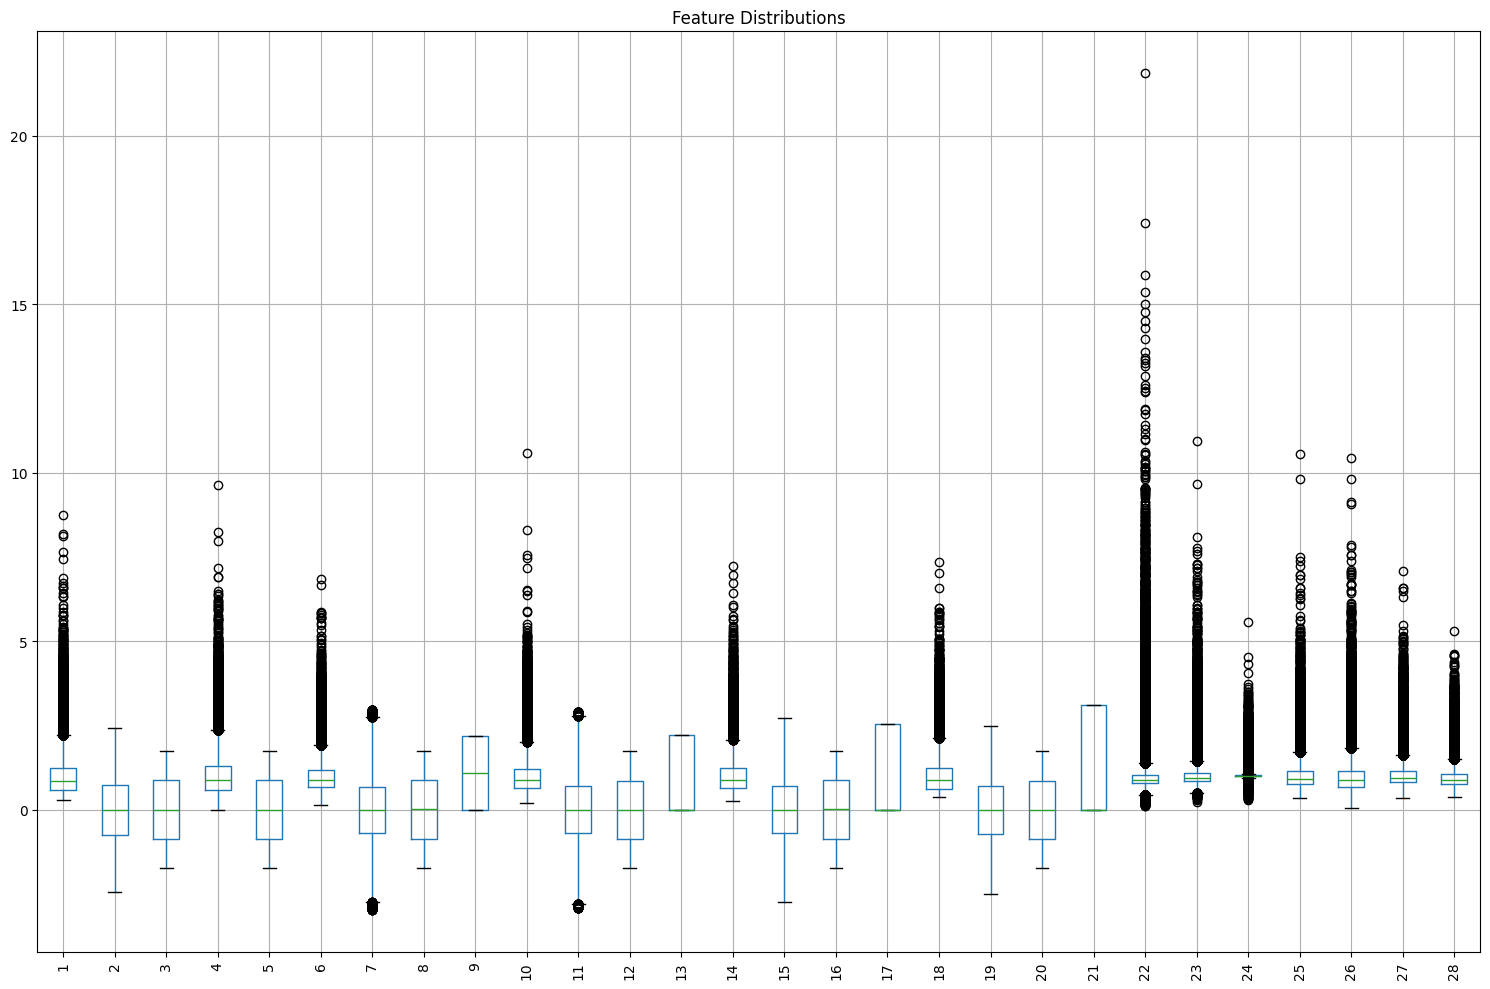

Saved figure to: outputs/eda/feature_correlation_heatmap.png


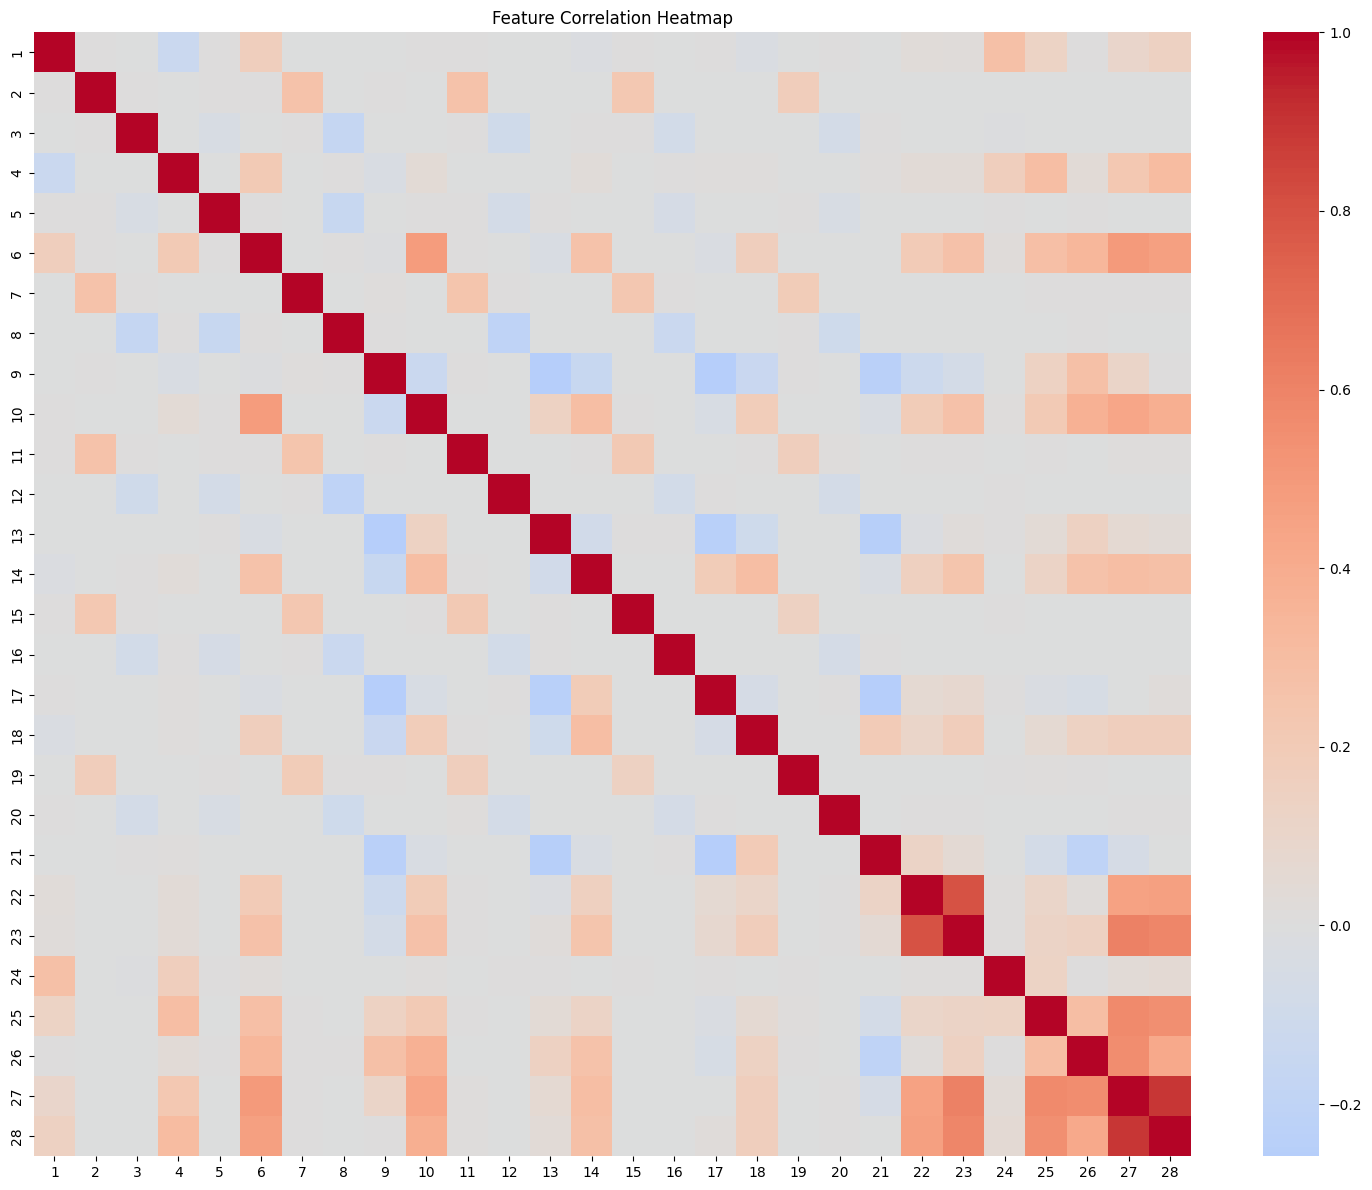


Top 10 Selected Features:
1. Feature 1
2. Feature 4
3. Feature 6
4. Feature 13
5. Feature 18
6. Feature 23
7. Feature 25
8. Feature 26
9. Feature 27
10. Feature 28
Saved SelectKBest top-10 features CSV.

Linear SVM Performance:
Cross-Validation Scores: [0.62829545 0.629375   0.63420455 0.63153409 0.63340909]
Mean CV Score: 0.6313636363636363

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.53      0.57     10352
         1.0       0.63      0.71      0.67     11648

    accuracy                           0.63     22000
   macro avg       0.63      0.62      0.62     22000
weighted avg       0.63      0.63      0.63     22000

Saved model: outputs/models/linear_sgd_svm.joblib
Saved figure to: outputs/metrics/linear_svm_confusion_matrix.png


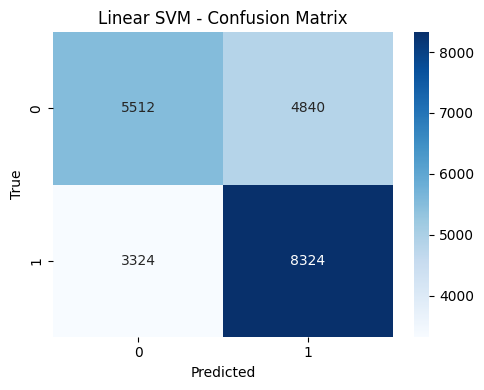

Saved figure to: outputs/metrics/linear_svm_roc.png


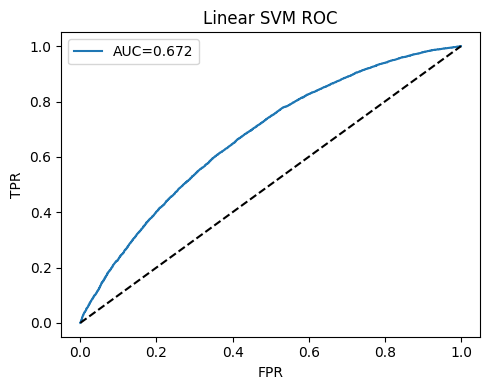


Evaluating all kernel configurations in parallel...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  3.7min remaining:  1.2min



Kernel Comparison Results (Sorted by Accuracy):
                       Accuracy  Precision    Recall  F1 Score  Training Time  \
RBF (gamma=auto)       0.641909   0.658032  0.673850  0.665847      52.823728   
RBF (gamma=scale)      0.641591   0.657672  0.673764  0.665621      50.278906   
Polynomial (degree=2)  0.641364   0.655033  0.681576  0.668041      50.317231   
Polynomial (degree=3)  0.631136   0.647098  0.667153  0.656973      63.109985   
RBF (gamma=0.1)        0.625682   0.647967  0.641569  0.644752      55.964201   
Polynomial (degree=4)  0.612545   0.631327  0.644660  0.637924      86.876745   
RBF (gamma=1.0)        0.529455   0.529455  1.000000  0.692344      45.790122   
Sigmoid (gamma=scale)  0.491091   0.520826  0.485234  0.502400      42.873155   

                       Prediction Time       AUC  
RBF (gamma=auto)              7.998292  0.693135  
RBF (gamma=scale)             7.596299  0.692939  
Polynomial (degree=2)         2.720163  0.688752  
Polynomial (degre

[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.5min finished



Best Hyperparameters:
{'svm__learning_rate': 'optimal', 'svm__eta0': 0.1, 'svm__alpha': 0.001}

Best Cross-Validation Score:
0.6275992100499468

Best Model Performance:
              precision    recall  f1-score   support

         0.0       0.63      0.50      0.56     10352
         1.0       0.62      0.74      0.68     11648

    accuracy                           0.63     22000
   macro avg       0.63      0.62      0.62     22000
weighted avg       0.63      0.63      0.62     22000


Evaluating hyperparameter sensitivity...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  8.4min finished


Saved figure to: outputs/hyperparam/rbf_svc_sensitivity_heatmap.png


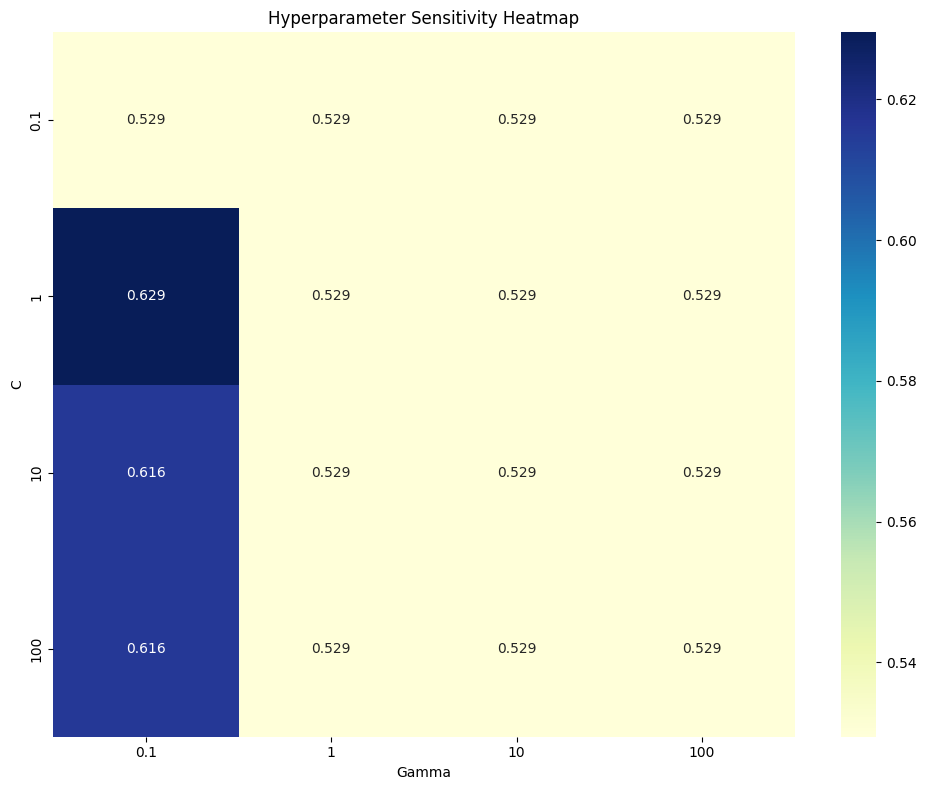

Creating SHAP explainer...
Calculating SHAP values for 100 samples...


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-3284434373.py:658: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Saved figure to: outputs/shap/shap_importance_bar.png


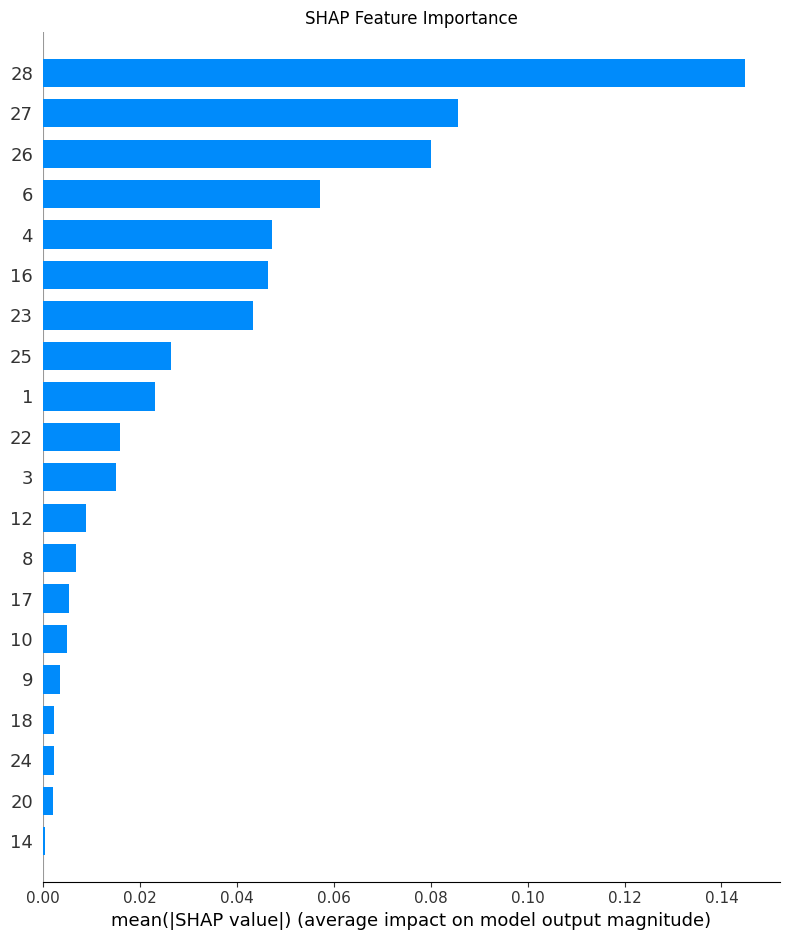

/tmp/ipython-input-3284434373.py:674: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Saved figure to: outputs/shap/shap_summary.png


<Figure size 640x480 with 0 Axes>

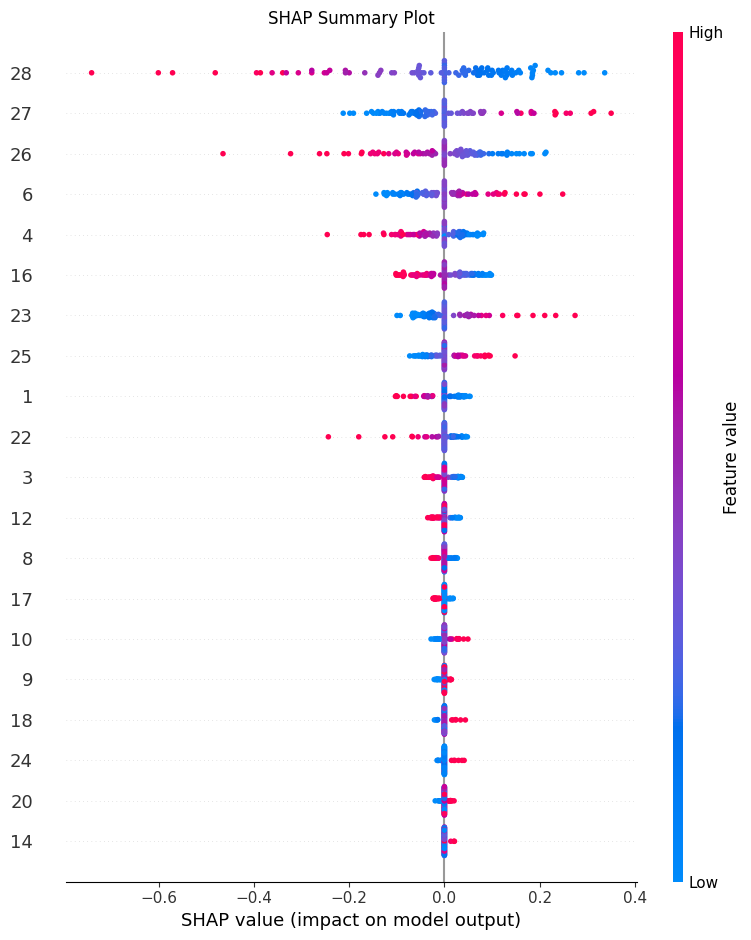

In [2]:
def main():

    higgs_analysis = HIGGSDatasetAnalysis('/content/drive/MyDrive/HIGGS.csv')

    # Preprocess data
    higgs_analysis.preprocess_data()

    # Exploratory Data Analysis
    higgs_analysis.exploratory_data_analysis()

    # Feature Selection
    selected_features, feature_names = higgs_analysis.feature_selection()

    # Linear SVM
    linear_svm = higgs_analysis.train_linear_svm()

    # Kernel Comparison
    kernel_results = higgs_analysis.kernel_comparison()

    # Hyperparameter Tuning
    best_model = higgs_analysis.hyperparameter_tuning()

    # Hyperparameter Sensitivity
    higgs_analysis.hyperparameter_sensitivity()

    analysis_results = model_comparison_and_shap_analysis(
        higgs_analysis,
        linear_svm,
        kernel_results,
        best_model
    )

if __name__ == "__main__":
    main()